In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

In [2]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/Volumes/xenon/datasets/celebA/celeba-dataset",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [20]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))

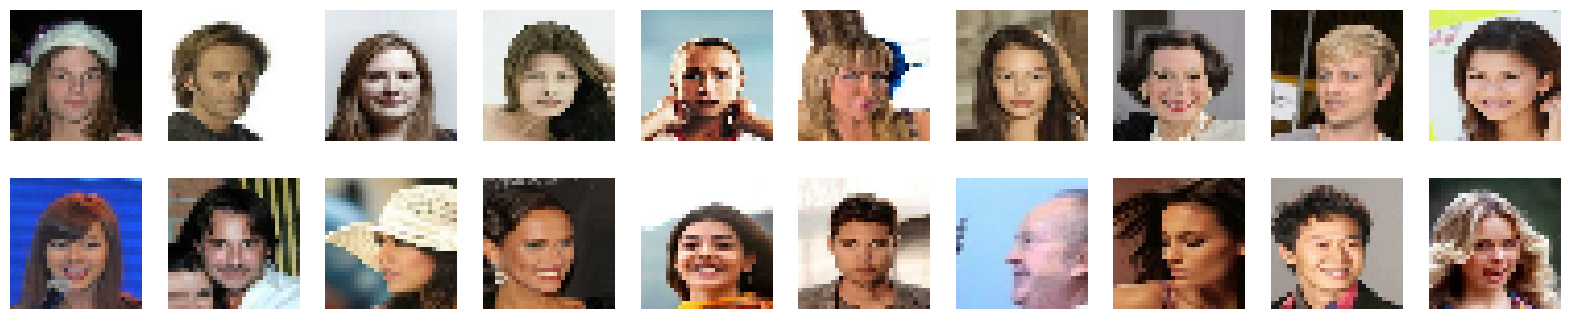

In [38]:
# Display some images from the first batch of the dataset

for images in train.take(1):
    plt.figure(figsize=(20, 4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

In [28]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Compute the latent space vectors (z) by adding the mean (z_mean) to the product of the standard deviation (square root of the variance) and the random noise (epsilon).
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [31]:
# Encoder

# Input layer
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")

# 4 equal layers of the pattern Conv2D, Batch Normalization, LeakyReLu
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Preserve for decoder 
shape_before_flattening = K.int_shape(x)[1:] #decoder needs this so the output shape matches input shape

# Flatten and fully connect
x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 16, 16, 128)          3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_4 (Bat  (None, 16, 16, 128)          512       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)          0         ['batch_normalization_4[